# Test dialog



# Prepare the data

X range : -500, 500
y range : -500, 500
t range : 0, 10

random (t,x,y) -> calculate a, and get the field

In [1]:
import numpy as np
import dfield_generator as dg

def get_random_txy(num = 10000,xrange = 1000, yrange = 1000,trange = 10):
    
    axy = np.zeros((num, 3))
    Bxy = np.zeros((num, 2))
    np.random.seed(0)
    
    t = trange*np.random.random([num])
    
    x = xrange* np.random.random([num]) - xrange * 0.5
    
    y = yrange * np.random.random([num]) - yrange*0.5
    axy[:,0] = np.sin(t)
    axy[:,1] = x
    axy[:,2] = y
    print('start...')
    for i in range(num):
        
        
        
        
        
        
        
        polar1 = dg.DipoleMoment(name = 1, position = [500,0],
                             alpha= np.radians(9.6),
                             B0 = 5e6,outputinfo=False)
        theta0 = -30.6
        s0 = 62
        n,th = 5,600
        a = axy[i,0]
        theta = theta0 + n*a
        s = s0 + th*a
        
        polar2 = dg.DipoleMoment(name = 2, position = [-1000,0],
                             alpha= np.radians(theta),
                             B0 = 1e6 * s,outputinfo=False)
        X, Y = axy[i,1],axy[i,2]
        Bx_1, By_1 = polar1.get_field(X,Y)
        Bx_2, By_2 = polar2.get_field(X,Y)
        Bx, By = Bx_1 + Bx_2, By_1 + By_2
        
        Bxy[i,:] = [Bx, By]

        
        if i % int(num / 10) == 0:
            print('Progress: ', np.round(i / num * 100, -1), '%')
    return axy,Bxy

axy,Bxy = get_random_txy(num = 100000,xrange = 800, yrange = 800,trange = 10)

start...
Progress:  0.0 %
Progress:  10.0 %
Progress:  20.0 %
Progress:  30.0 %
Progress:  40.0 %
Progress:  50.0 %
Progress:  60.0 %
Progress:  70.0 %
Progress:  80.0 %
Progress:  90.0 %


## Add noise
Add noise on a, Bx, By

In [2]:
a_noise = axy[:,0] + np.random.normal(0, 0.1, axy[:,0].shape)
print(a_noise)
print(axy[:,0])
axy_noise = axy.copy()
axy_noise[:,0] = a_noise
print(axy)
print(Bxy.shape)
print(axy.shape)

[-0.64598749  0.6788354  -0.24633468 ...  0.96426323 -0.71500378
  0.91422892]
[-0.71389881  0.76349541 -0.25277908 ...  0.96956544 -0.69818742
  0.77330293]
[[-7.13898806e-01  2.82056586e+01 -2.25784110e+02]
 [ 7.63495414e-01  3.23235398e+02  6.97997799e+01]
 [-2.52779082e-01  1.91725566e+00  3.90090640e+02]
 ...
 [ 9.69565438e-01 -2.28300411e+02  9.42170980e+01]
 [-6.98187424e-01 -1.63378710e+02 -1.31249270e+02]
 [ 7.73302927e-01  2.74003351e+02  6.35055261e+01]]
(100000, 2)
(100000, 3)


## Compare the real field and model field

set a = 0, a = 1, a = -1, compare the different model field


3 plots

In [3]:

axy_f,Bxy_f  = get_random_txy(num = 400000,xrange = 800, yrange = 800,trange = 10)

start...
Progress:  0.0 %
Progress:  10.0 %
Progress:  20.0 %
Progress:  30.0 %
Progress:  40.0 %
Progress:  50.0 %
Progress:  60.0 %
Progress:  70.0 %
Progress:  80.0 %
Progress:  90.0 %


In [4]:
hp = {}
    # Data size on the initial condition solution
hp["N_0"] = 100000

# Collocation points on the domain
hp["N_f"] = 400000
# DeepNN topology (3 sized input[a,x,y], 4 hidden layer of 30-width, 2-sized output [Bx,By])
hp["layers"] = [3, 30, 30, 30, 2]
    # Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
hp["tf_epochs"] = 2000
hp["tf_lr"] = 0.001
hp["tf_b1"] = 0.9
hp["tf_eps"] = 1e-7
    # Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
hp["nt_epochs"] = 0
hp["nt_lr"] =1.2
hp["nt_ncorr"] = 50
hp["log_frequency"] = 10

In [5]:
from utils.logger import Logger
from DL_PINN import BFieldInformedNN
logger = Logger(hp)
pinn_0 = BFieldInformedNN(hp,logger,axy_f,0,0,alpha = 0)

b_star = np.sqrt(Bxy[:,0]**2 + Bxy[:,1]**2)

def error():
    bx_pred, by_pred = pinn_0.predict(X_train)
    b_pred = np.sqrt(bx_pred**2 + by_pred**2)
    return np.linalg.norm(b_star - b_pred, 2) / np.linalg.norm(b_star, 2)


logger.set_error_fn(error)

Hyperparameters:
{
  "N_0": 100000,
  "N_f": 400000,
  "layers": [
    3,
    30,
    30,
    30,
    2
  ],
  "tf_epochs": 2000,
  "tf_lr": 0.001,
  "tf_b1": 0.9,
  "tf_eps": 1e-07,
  "nt_epochs": 0,
  "nt_lr": 1.2,
  "nt_ncorr": 50,
  "log_frequency": 10
}

TensorFlow version: 2.1.0
Eager execution: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU-accerelated: True


In [7]:
import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
pinn_0.fit(axy_noise,Bxy)

RuntimeError: Physical devices cannot be modified after being initialized

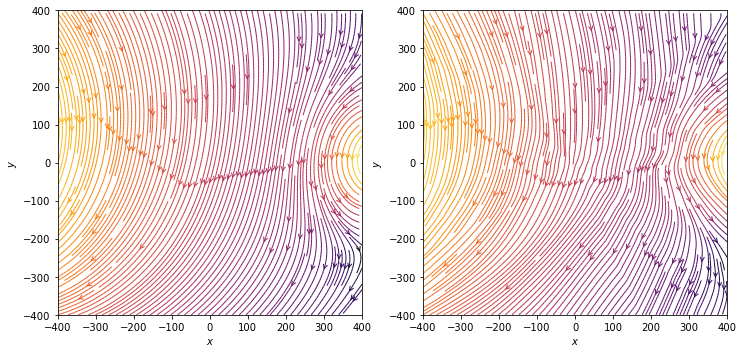

In [9]:
import matplotlib.pyplot as plt
def make_compare_plot_new(a,pinn):
    nx, ny = 500, 500
    XMAX, YMAX = 400, 400
    x = np.linspace(-XMAX, XMAX, nx)
    y = np.linspace(-YMAX, YMAX, ny)
    X, Y = np.meshgrid(x, y)
    
    
    theta0 = -30.6
    s0 = 62
    n,th = 5,600
    
    
    theta = theta0 + n*a
    s = s0 + th*a

    polar1 = dg.DipoleMoment(name = 1, position = [500,0],
                             alpha= np.radians(9.6),
                             B0 = 5e6,outputinfo=False)

    polar2 = dg.DipoleMoment(name = 2, position = [-1000,0],
                             alpha= np.radians(theta),
                             B0 = 1e6 * s,outputinfo=False)
    


    Bx_1, By_1 = polar1.get_field(X,Y)


    Bx_2, By_2 = polar2.get_field(X,Y)
    Bx, By = Bx_1 + Bx_2, By_1 + By_2


    fig,axs = plt.subplots(1,2, figsize = (12,6))

    # Plot the streamlines with an appropriate colormap and arrow style
    color = 2 * np.log(np.hypot(Bx, By))
    axs[0].streamplot(x, y, Bx, By, color=color, linewidth=1, cmap=plt.cm.inferno,
              density=3, arrowstyle='->', arrowsize=1)


    axs[0].set_xlabel('$x$')
    axs[0].set_ylabel('$y$')
    axs[0].set_xlim(-XMAX, XMAX)
    axs[0].set_ylim(-YMAX, YMAX)
    axs[0].set_aspect('equal')
    
    
    positions = np.vstack([X.ravel(), Y.ravel()])
    axy_new = np.zeros((len(positions.T),3))
    axy_new[:,0] = a
    axy_new[:,1:] = positions.T
    
    
    #result = np.array(model(axy_new))
    result_pinn_Bx,result_pinn_By = pinn.predict(axy_new)
    
    
    
    
    Bx_model_pinn ,By_model_pinn = result_pinn_Bx.reshape((nx,ny)),result_pinn_By.reshape((nx,ny))
    
    
    axs[1].streamplot(x, y, Bx_model_pinn ,By_model_pinn, color=color, linewidth=1, cmap=plt.cm.inferno,
              density=3, arrowstyle='->', arrowsize=1)


    axs[1].set_xlabel('$x$')
    axs[1].set_ylabel('$y$')
    axs[1].set_xlim(-XMAX, XMAX)
    axs[1].set_ylim(-YMAX, YMAX)
    axs[1].set_aspect('equal')
    
    
    
    
    
    plt.show()
    

make_compare_plot_new(1,pinn_0)

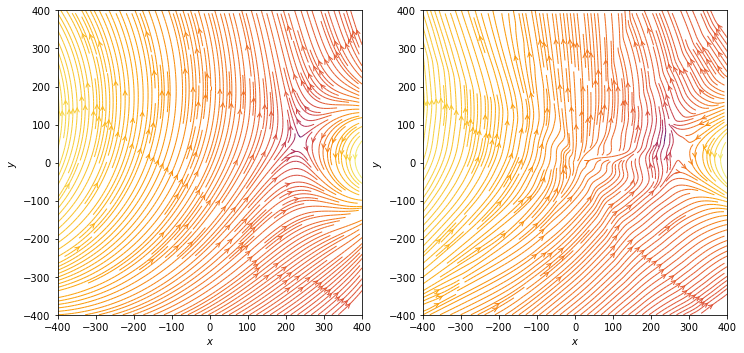

In [10]:

make_compare_plot_new(-1,pinn_0)

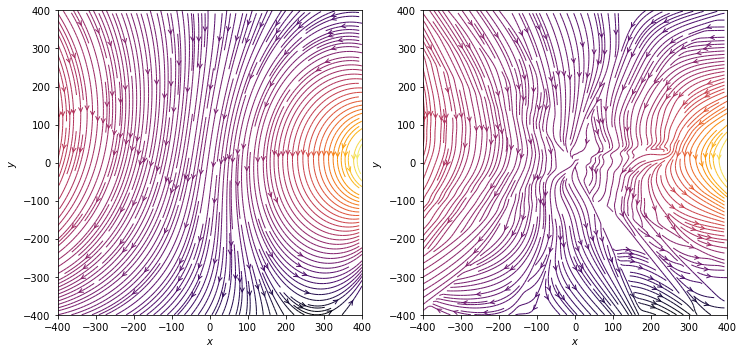

In [11]:
make_compare_plot_new(0,pinn_0)